Hacemos una EDA para ver el comportamiento de las variables y sus relaciones para ver como afectan a otras y tambien como afectan la variable target que es aqui si un cliente ha suscrito a un deposito a plazo.

# LIBRAIRIES

In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import chi2_contingency
import numpy as np
from scipy.stats import zscore, f_oneway
from scipy.stats import ttest_ind
from sklearn.feature_selection import mutual_info_classif

import warnings
warnings.filterwarnings("ignore")

In [5]:
ruta=r"..\data\fin_mark_full_mod.csv"
df_raw=pd.read_csv(ruta,sep=";")
df_raw.shape

(41188, 21)

In [6]:
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         40198 non-null  object 
 6   loan            40198 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41093 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

Vamos a cambiar el tipo de algunas de variables porque no estan bien hechas (ej: is_suscribed in object, nr.employed in object)

In [12]:
df_raw['is_suscribed'] = df_raw['is_suscribed'].astype('object')
df_raw['nr.employed'] = df_raw['nr.employed'].astype('object')

In [7]:
df_raw.head()

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,...,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,is_suscribed
0,56,housemaid,married,basic.4y,no,no,no,telephone,may,mon,...,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
1,57,services,married,high.school,unknown,no,no,telephone,may,mon,...,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
2,37,services,married,high.school,no,yes,no,telephone,may,mon,...,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
3,40,admin.,married,basic.6y,no,no,no,telephone,may,mon,...,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0
4,56,services,married,high.school,no,no,yes,telephone,may,mon,...,1,-1,0,nonexistent,1.1,93.994,-36.4,4.857,5191.0,0


In [13]:
df_raw.isnull().sum()[df_raw.isnull().sum()>0].sort_values(ascending=False)

housing         990
loan            990
emp.var.rate     95
euribor3m        60
dtype: int64

Tenemos nulos que tratar y tambien tendremos que aprofundizar la variable marital porque parece que tenemos nulos pero no sabemos como estan registrados.

In [14]:
numeric_cols = [col for col in df_raw.columns if df_raw[col].dtype in ['int64', 'float64']]
str_cols = [col for col in df_raw.columns if df_raw[col].dtype == 'object']
print(f"Numeric columns: {numeric_cols}")
print(f"String columns: {str_cols}")

Numeric columns: ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx', 'euribor3m']
String columns: ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'month', 'day_of_week', 'poutcome', 'nr.employed', 'is_suscribed']


# ANALISIS UNIVARIANTE

In [15]:
for col in df_raw.columns:
    value_counts = df_raw[col].value_counts().head(10)
    percentage = round(value_counts/df_raw.shape[0] * 100,2)
    print("\033[1m\033[4m" + col + "\033[0m")
    print(pd.DataFrame({'Valeur': value_counts.index, 'Nombre': value_counts.values, 'Pourcentage': percentage.values}))
    print(f"Type {df_raw[col].dtype}")
    print("-----------------------------")

age
   Valeur  Nombre  Pourcentage
0      31    1947         4.73
1      32    1846         4.48
2      33    1833         4.45
3      36    1780         4.32
4      35    1759         4.27
5      34    1745         4.24
6      30    1714         4.16
7      37    1475         3.58
8      29    1453         3.53
9      39    1432         3.48
Type int64
-----------------------------
job
          Valeur  Nombre  Pourcentage
0         admin.   10422        25.30
1    blue-collar    9254        22.47
2     technician    6743        16.37
3       services    3969         9.64
4     management    2924         7.10
5        retired    1720         4.18
6   entrepreneur    1456         3.54
7  self-employed    1421         3.45
8      housemaid    1060         2.57
9     unemployed    1014         2.46
Type object
-----------------------------
marital
     Valeur  Nombre  Pourcentage
0   married   24928        60.52
1    single   11568        28.09
2  divorced    4612        11.20
3   unknow

Sobre la variable marital tenemos 80 'unknown' que podemos afectar como NaN o simplemente cambiar por la moda. Tenemos el mismo problema sobre la education\
Por la variable target, vemos que tenemos una menor populacion de personas que han suscrito a un deposito a plazo (11%). se puede afectar el modelo mas tarde (pensar en un undersampling y bien hacer la estratificacion).

## QUANTITATIVE

In [17]:
df_raw[numeric_cols].describe(percentiles=[0.25,0.5,0.75,0.9,0.95,0.99]).T.style.background_gradient(cmap='coolwarm')

,count,mean,std,min,25%,50%,75%,90%,95%,99%,max
age,41188.000000,40.024060,10.421250,17.000000,32.000000,38.000000,47.000000,55.000000,58.000000,71.000000,98.000000
duration,41188.000000,258.285010,259.279249,0.000000,102.000000,180.000000,319.000000,551.000000,752.650000,1271.130000,4918.000000
campaign,41188.000000,2.567593,2.770014,1.000000,1.000000,2.000000,3.000000,5.000000,7.000000,14.000000,56.000000
pdays,41188.000000,-0.741988,1.510327,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,6.000000,27.000000
previous,41188.000000,0.172963,0.494901,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,2.000000,7.000000
emp.var.rate,41093.000000,0.081194,1.571155,-3.400000,-1.800000,1.100000,1.400000,1.400000,1.400000,1.400000,1.400000
cons.price.idx,41188.000000,93.575664,0.578840,92.201000,93.075000,93.749000,93.994000,94.465000,94.465000,94.465000,94.767000
cons.conf.idx,41188.000000,-40.502600,4.628198,-50.800000,-42.700000,-41.800000,-36.400000,-36.100000,-33.600000,-26.900000,-26.900000
euribor3m,41128.000000,3.620922,1.734545,0.634000,1.344000,4.857000,4.961000,4.964000,4.966000,4.968000,5.045000


Parece con este visual que tenemos outliers porque tenemos valores atypicas en duration, campain, pdays, previous porque hay una gran diferencia entre el percentil 95% y 99% y el maximo. Tenemos que hacer una visualizacion para ver esto mas en detalle.

In [20]:
df_raw[numeric_cols].skew().sort_values(ascending=False)

pdays             7.322378
campaign          4.762507
previous          3.832042
duration          3.263141
age               0.784697
cons.conf.idx     0.303180
cons.price.idx   -0.230888
euribor3m        -0.708746
emp.var.rate     -0.723369
dtype: float64

In [21]:
df_raw[numeric_cols].kurt().sort_values(ascending=False)

pdays             64.002998
campaign          36.979795
duration          20.247938
previous          20.108816
age                0.791312
cons.conf.idx     -0.358558
cons.price.idx    -0.829809
emp.var.rate      -1.063573
euribor3m         -1.407425
dtype: float64

Parece que tenemos variables con distribucion con no tan asymetria y tenemos algunas con un grand curtosis como pdays y campain asi parece que hay picos.

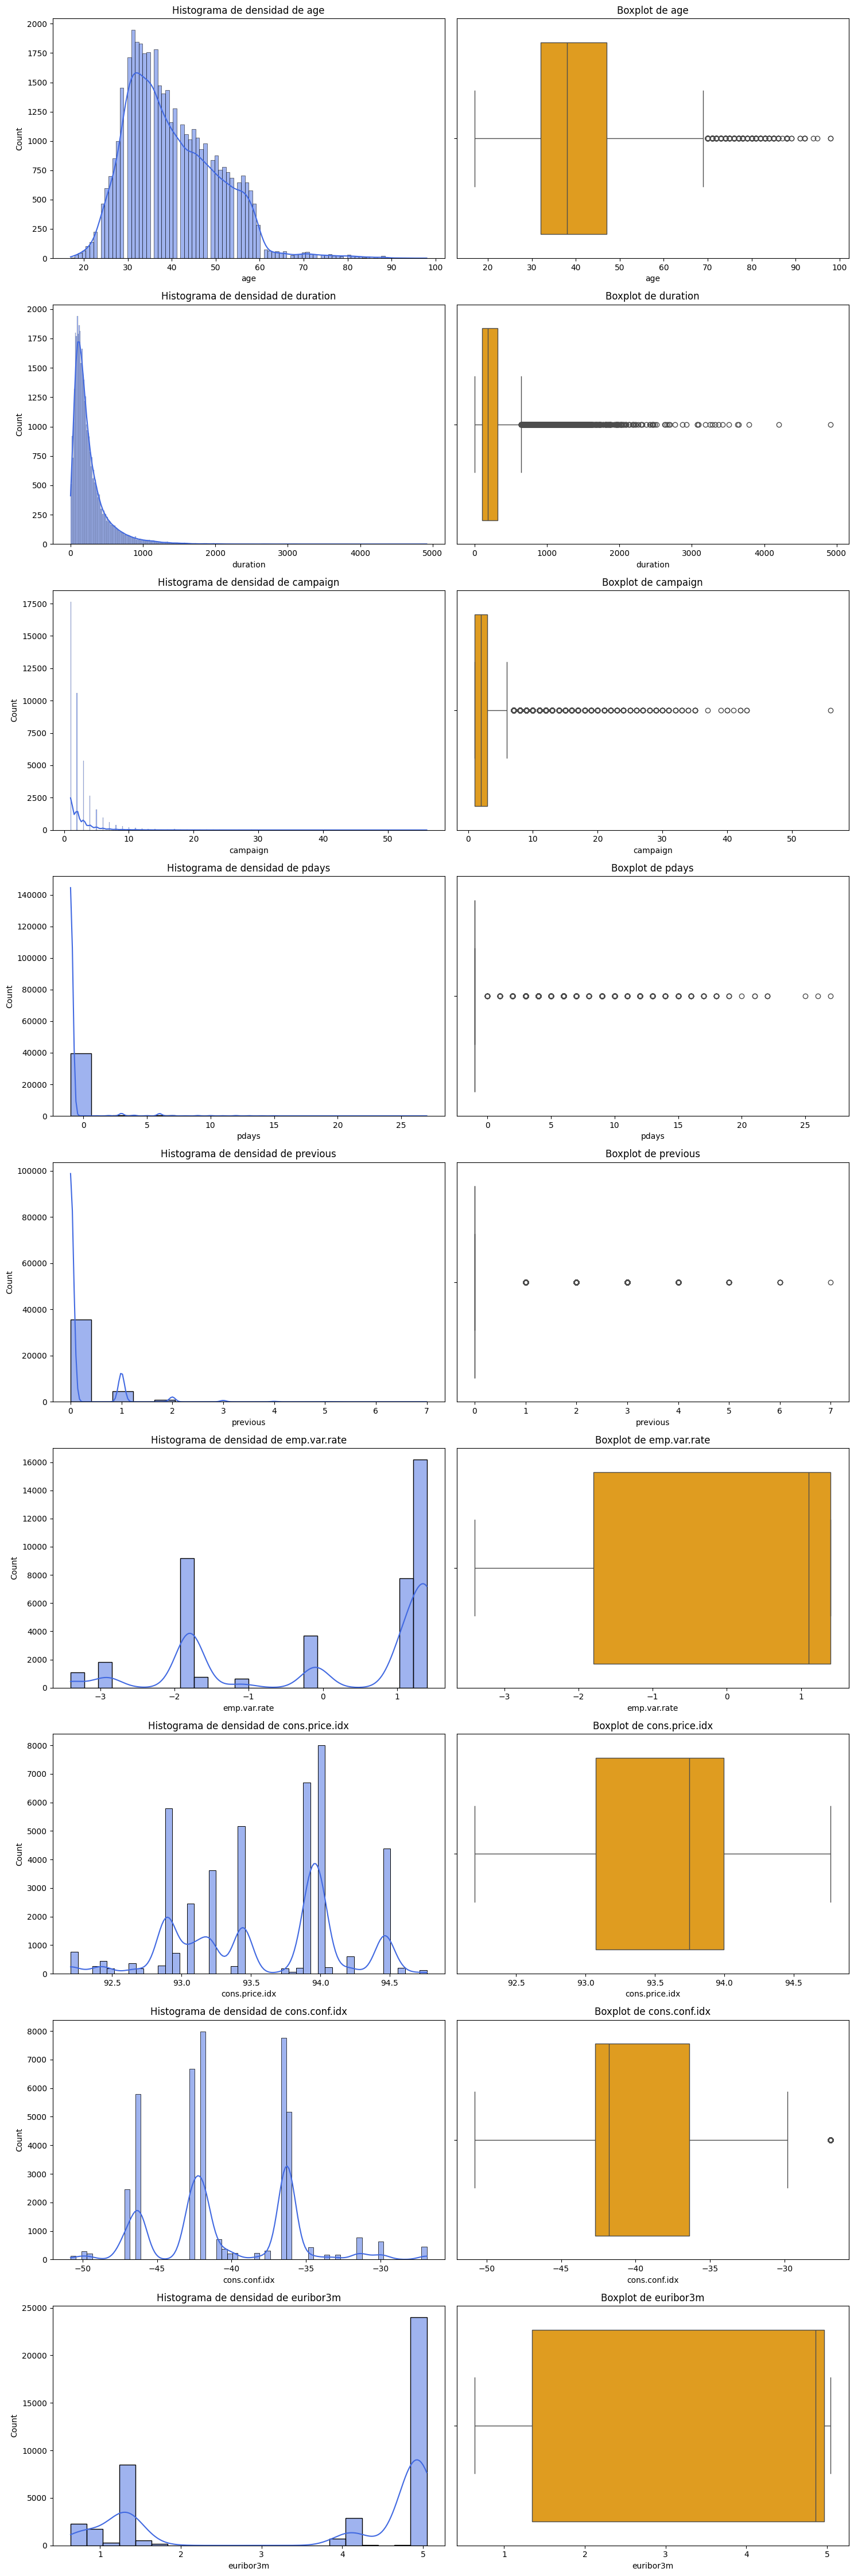

In [23]:
fig, axes = plt.subplots(nrows=len(df_raw[numeric_cols].columns), ncols=2, figsize=(15, 5 * len(df_raw[numeric_cols].columns)))

for i, column in enumerate(df_raw[numeric_cols]):
    # Histograma de densidad
    sns.histplot(df_raw[column], kde=True, ax=axes[i, 0], color='royalblue')
    axes[i, 0].set_title(f'Histograma de densidad de {column}')
    
    # Boxplot
    sns.boxplot(x=df_raw[column], ax=axes[i, 1], color='orange')
    axes[i, 1].set_title(f'Boxplot de {column}')



plt.tight_layout()
plt.show()